# Анализ и выделение признаков - лабораторная работа

## ИУ5 ОАД

### Цель:
Научиться анализировать данные и выделять из них полезные признаки, научиться пользоваться `seaborn` и `sklearn`, познакомиться с основными понятиями Data Science.

**Обратите внимание**, что в каждом разделе лабораторной работы есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — отсутствие ответов приравнивается к невыполненной лабораторной работе. Ответы без кода – аналогично.

In [ ]:
#!pip install pandas matplotlib seaborn

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
!pip install folium

In [1]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
df = pd.read_csv('train.csv')
df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку для обучения модели машинного обучения нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
df = df.drop('dropoff_datetime', axis=1)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

**Вопрос**: Почему нельзя использовать `dropoff_datetime` для обучения модели машинного обучения? Какие есть противоречия?

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

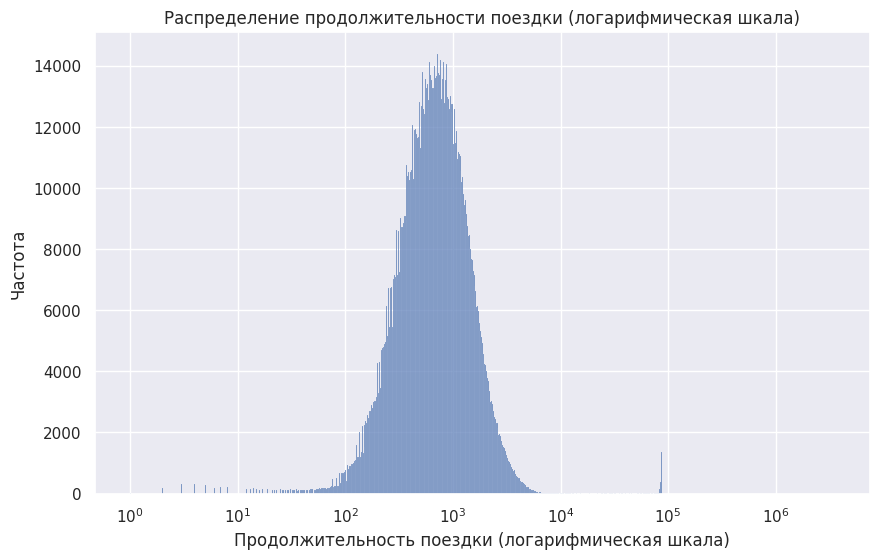

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['trip_duration'], log_scale=True)
plt.title('Распределение продолжительности поездки (логарифмическая шкала)')
plt.xlabel('Продолжительность поездки (логарифмическая шкала)')
plt.ylabel('Частота')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

## Часть 1. Изучаем `pickup_datetime`

**Задание 2**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

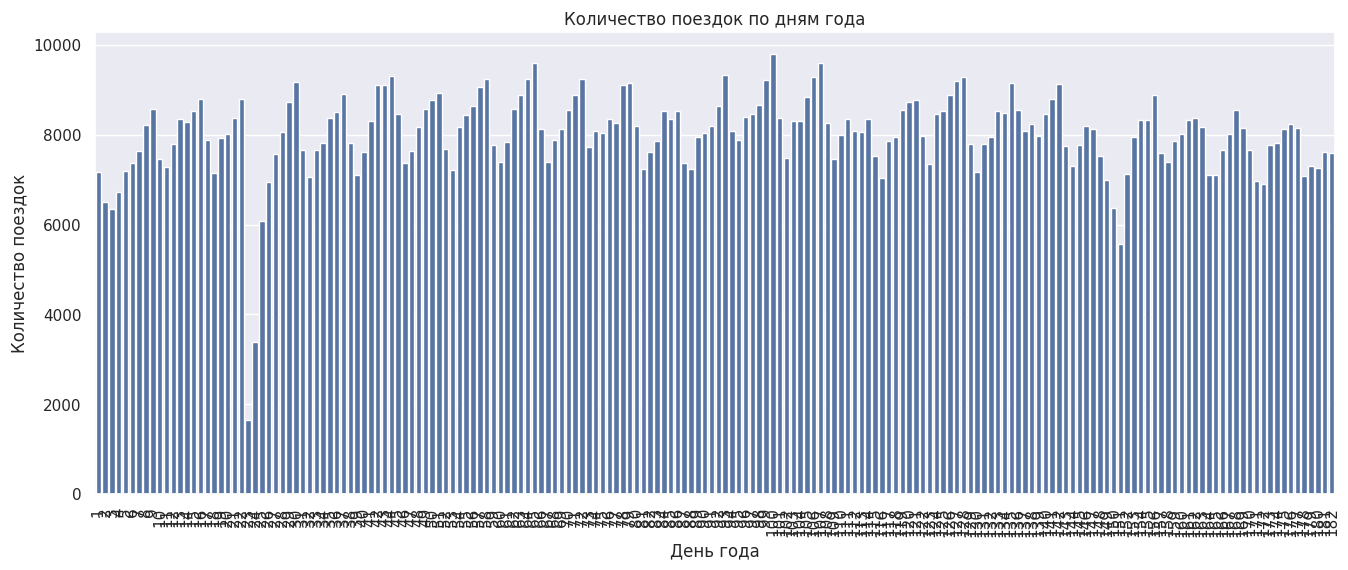

In [6]:
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear
plt.figure(figsize=(16, 6))
sns.countplot(x='day_of_year', data=df)
plt.title('Количество поездок по дням года')
plt.xlabel('День года')
plt.ylabel('Количество поездок')
plt.xticks(rotation=90)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

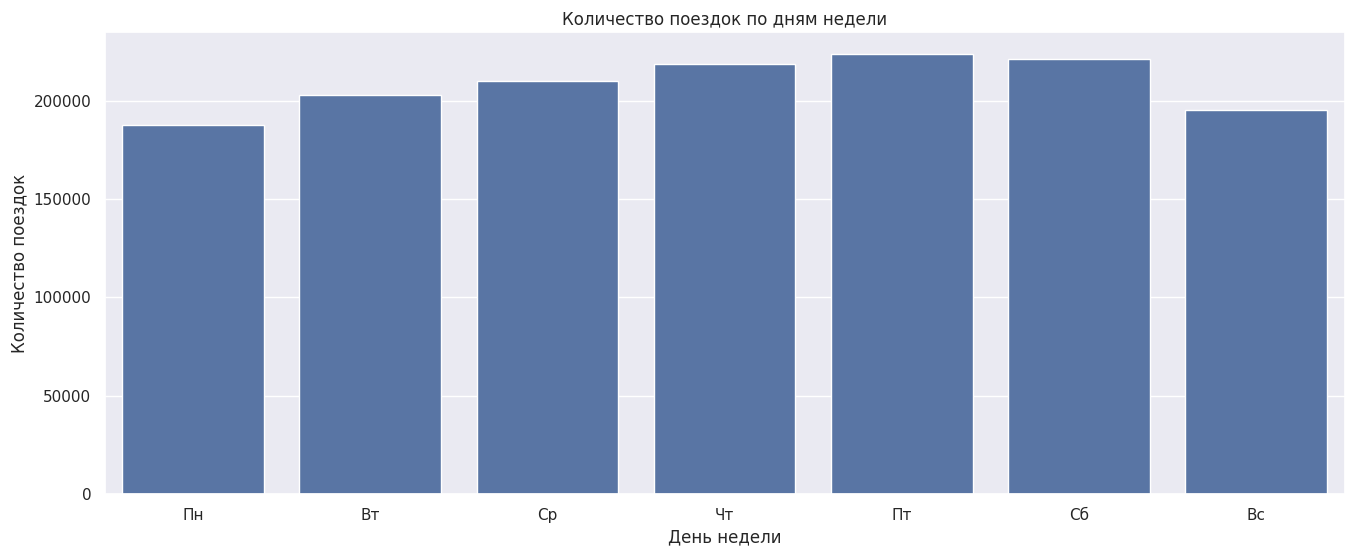

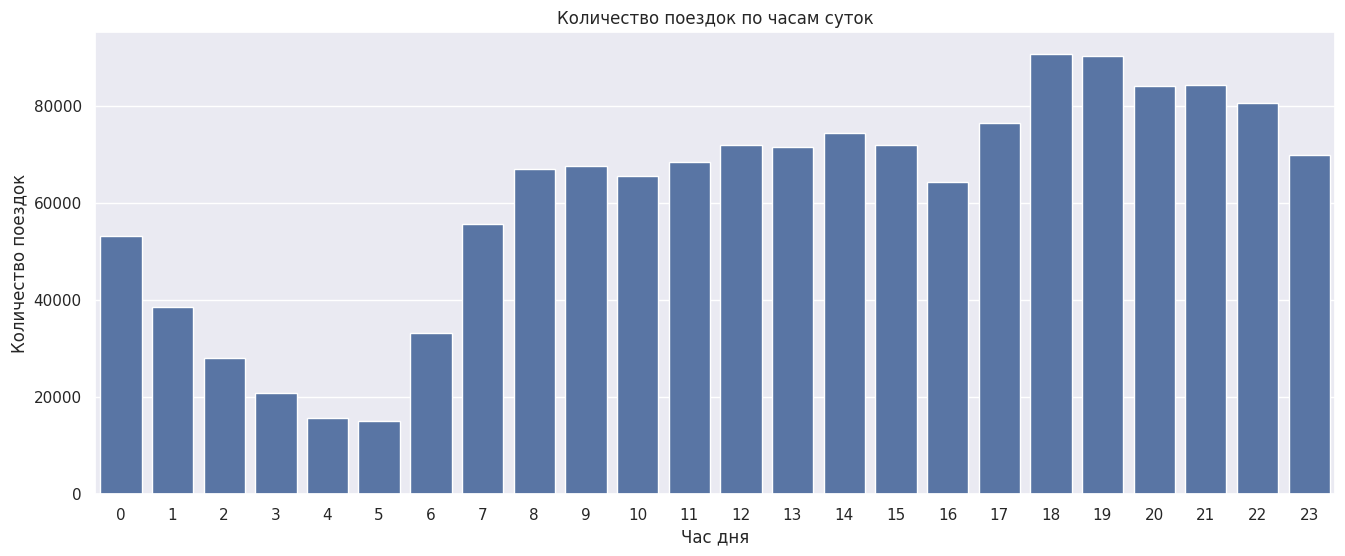

In [13]:
# Создаем новый столбец 'day_of_week' для дня недели (0 - понедельник, 6 - воскресенье)
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
# Создаем новый столбец 'hour_of_day' для часа в сутки
df['hour_of_day'] = df['pickup_datetime'].dt.hour

# График зависимости количества поездок от дня недели
plt.figure(figsize=(16, 6))
sns.countplot(x='day_of_week', data=df)
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

# График зависимости количества поездок от часов в сутках
plt.figure(figsize=(16, 6))
sns.countplot(x='hour_of_day', data=df)
plt.title('Количество поездок по часам суток')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.show()


**Задание 3**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

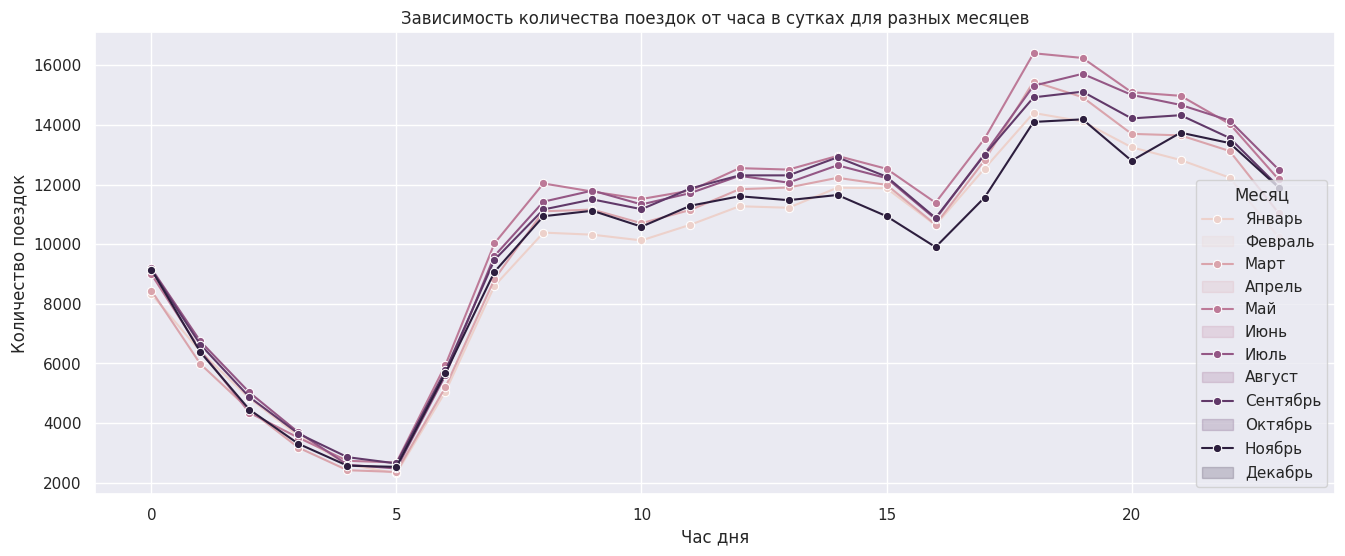

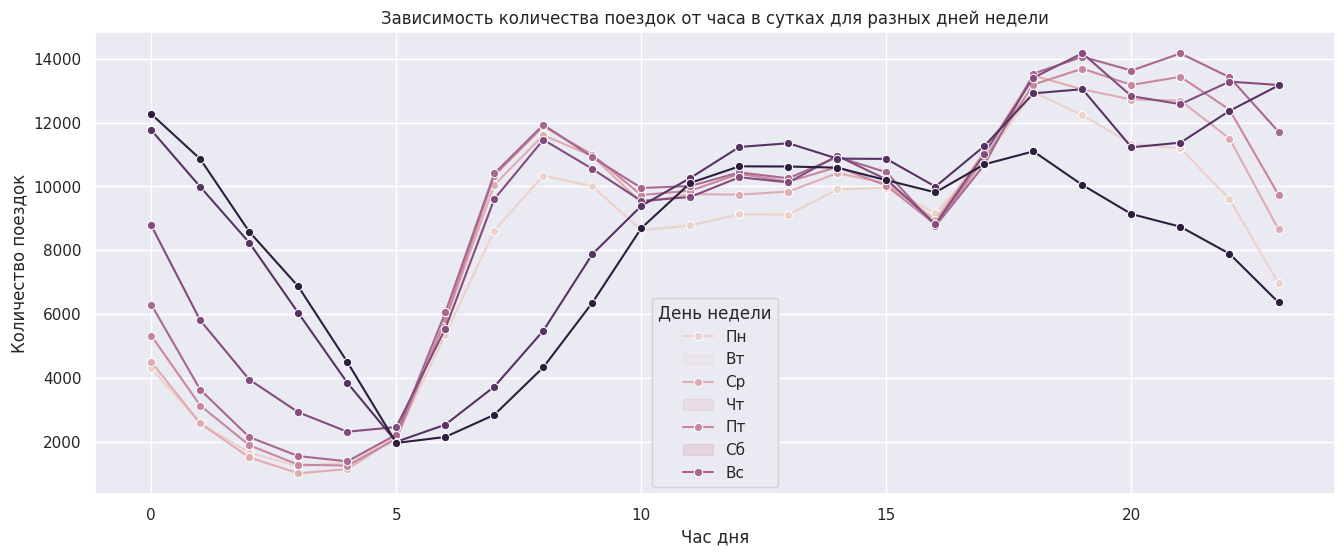

In [ ]:
# Создаем новый столбец 'month' для месяца
df['month'] = df['pickup_datetime'].dt.month
# Создаем новый столбец 'day_of_week' для дня недели
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
# Создаем новый столбец 'hour_of_day' для часа в сутки
df['hour_of_day'] = df['pickup_datetime'].dt.hour

# Подсчитываем количество поездок для каждого часа суток и месяца
df_monthly = df.groupby(['hour_of_day', 'month']).size().reset_index(name='trip_count')

# График зависимости количества поездок от часа в сутках для разных месяцев
plt.figure(figsize=(16, 6))
sns.lineplot(x='hour_of_day', y='trip_count', data=df_monthly, hue='month', marker='o')
plt.title('Зависимость количества поездок от часа в сутках для разных месяцев')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.legend(title='Месяц', labels=['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
plt.show()

# Подсчитываем количество поездок для каждого часа суток и дня недели
df_weekly = df.groupby(['hour_of_day', 'day_of_week']).size().reset_index(name='trip_count')

# График зависимости количества поездок от часа в сутках для разных дней недели
plt.figure(figsize=(16, 6))
sns.lineplot(x='hour_of_day', y='trip_count', data=df_weekly, hue='day_of_week', marker='o')
plt.title('Зависимость количества поездок от часа в сутках для разных дней недели')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.legend(title='День недели', labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4**. Разбейте выборку на обучающую и тестовую в отношении 7:3, представьте, что вы готовите данные для обучения модели машинного обучения (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

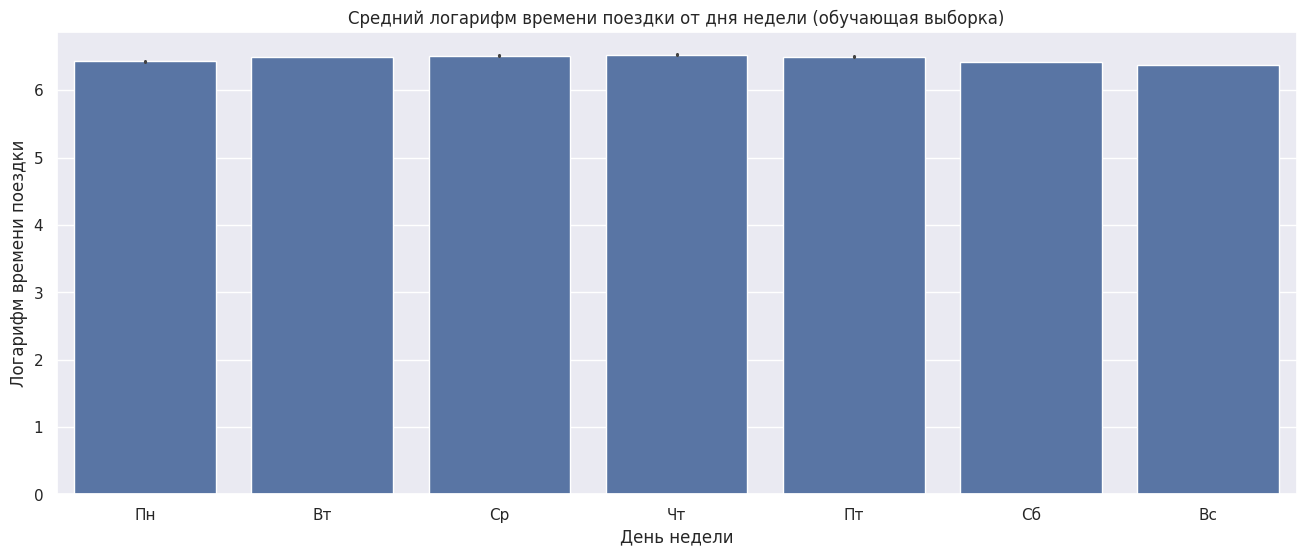

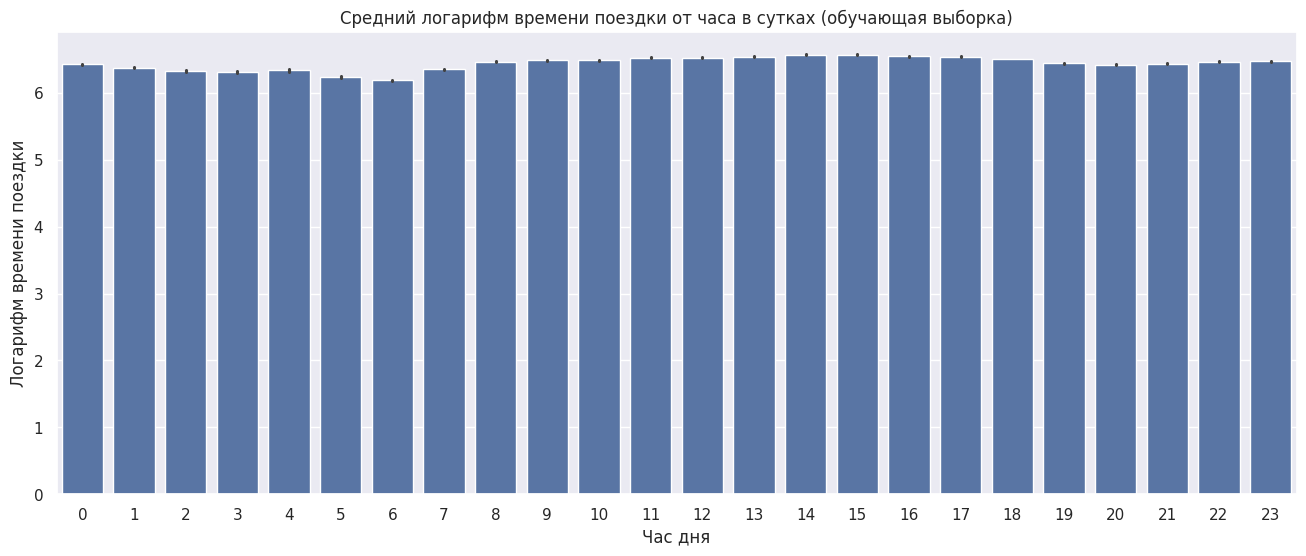

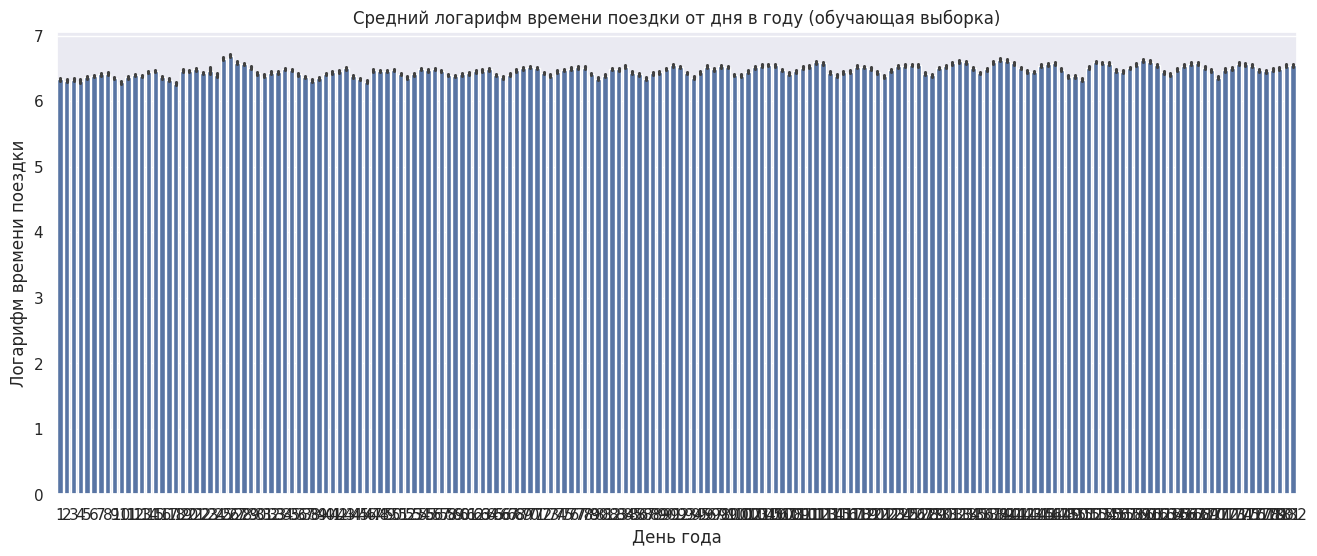

In [20]:
from sklearn.model_selection import train_test_split

# Преобразуем 'pickup_datetime' в необходимые столбцы
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # 0 - Понедельник, 6 - Воскресенье
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear

# Логарифмируем продолжительность поездки, добавив 1, чтобы избежать логарифмирования 0
df['log_trip_duration'] = np.log(df['trip_duration'] + 1)

# Разделяем данные на обучающую и тестовую выборки (7:3)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# График зависимости среднего логарифма времени поездки от дня недели
plt.figure(figsize=(16, 6))
sns.barplot(x=train_df['day_of_week'], y=train_df['log_trip_duration'], data=train_df)
plt.title('Средний логарифм времени поездки от дня недели (обучающая выборка)')
plt.xlabel('День недели')
plt.ylabel('Логарифм времени поездки')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

# График зависимости среднего логарифма времени поездки от часа в сутках
plt.figure(figsize=(16, 6))
sns.barplot(x=train_df['hour_of_day'], y=train_df['log_trip_duration'], data=train_df)
plt.title('Средний логарифм времени поездки от часа в сутках (обучающая выборка)')
plt.xlabel('Час дня')
plt.ylabel('Логарифм времени поездки')
plt.show()

# График зависимости среднего логарифма времени поездки от дня в году
plt.figure(figsize=(16, 6))
sns.barplot(x=train_df['day_of_year'], y=train_df['log_trip_duration'], data=train_df)
plt.title('Средний логарифм времени поездки от дня в году (обучающая выборка)')
plt.xlabel('День года')
plt.ylabel('Логарифм времени поездки')
plt.show()


**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [21]:
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

df['month'] = df['pickup_datetime'].dt.month

df['hour'] = df['pickup_datetime'].dt.hour

df['day_of_year'] = df['pickup_datetime'].dt.dayofyear

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [22]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [23]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [24]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Задание 5**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    # Радиус Земли в километрах
    R = 6371.0

    # Преобразуем широты и долготы из градусов в радианы
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Разницы в координатах
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Формула Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Расстояние
    distance = R * c
    return distance

train_df['haversine'] = haversine(train_df['pickup_latitude'],
                                     train_df['pickup_longitude'],
                                     train_df['dropoff_latitude'],
                                     train_df['dropoff_longitude'])
print(train_df.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'day_of_year', 'day_of_week', 'hour_of_day', 'month',
       'log_trip_duration', 'haversine'],
      dtype='object')


Так как мы можем предсказывать логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [27]:
train_df['log_haversine'] = np.log1p(train_df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [28]:
your_df = train_df
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 6**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

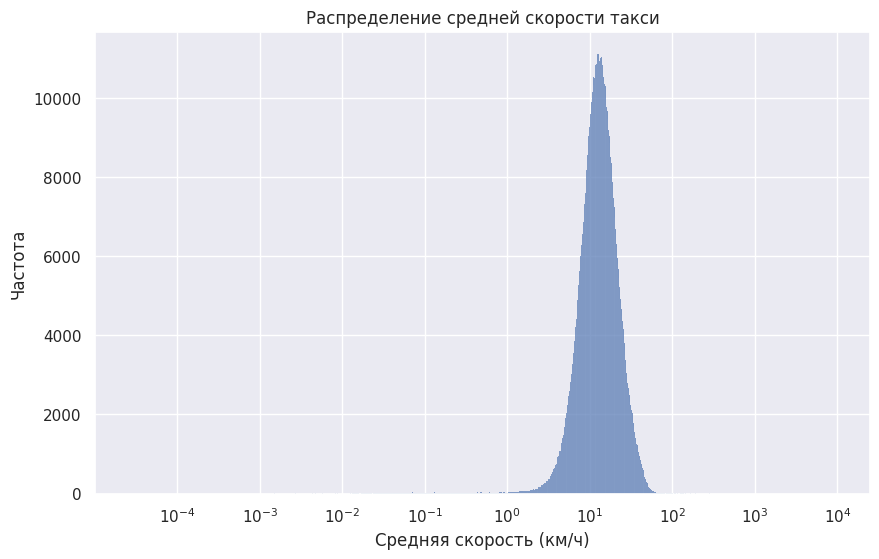

In [30]:
# Рассчитываем среднюю скорость
train_df['avg_speed'] = train_df['haversine'] * 3600 / train_df['trip_duration']

# Строим гистограмму распределения средней скорости
plt.figure(figsize=(10, 6))
sns.histplot(train_df['avg_speed'], log_scale=True)
plt.title('Распределение средней скорости такси')
plt.xlabel('Средняя скорость (км/ч)')
plt.ylabel('Частота')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

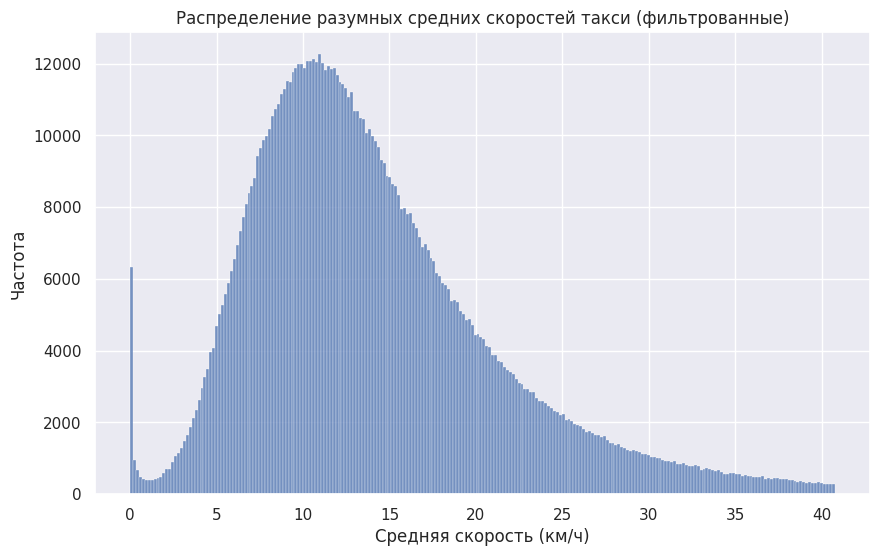

In [31]:
# Рассчитываем среднюю скорость в км/ч
train_df['avg_speed'] = train_df['haversine'] * 3600 / train_df['trip_duration']

# Определяем порог для разумной скорости (например, 99-й перцентиль)
speed_threshold = train_df['avg_speed'].quantile(0.99)

# Фильтруем DataFrame, оставляя только разумные скорости
filtered_train_df = train_df[train_df['avg_speed'] <= speed_threshold]

# Строим гистограмму распределения "разумных" средних скоростей
plt.figure(figsize=(10, 6))
sns.histplot(filtered_train_df['avg_speed'])
plt.title('Распределение разумных средних скоростей такси (фильтрованные)')
plt.xlabel('Средняя скорость (км/ч)')
plt.ylabel('Частота')
plt.show()


Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

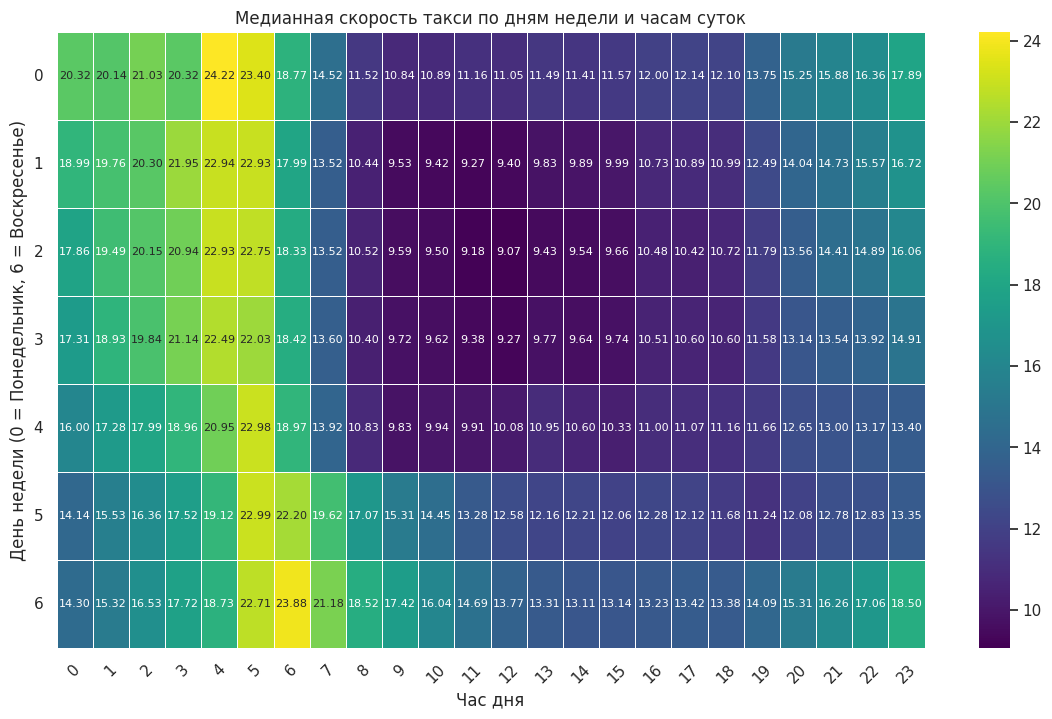

In [ ]:
# Рассчитываем среднюю скорость
train_df['avg_speed'] = train_df['haversine'] * 3600 / train_df['trip_duration']

# Группируем по дню недели и часу суток, вычисляем медиану скорости
median_speeds = train_df.groupby([train_df['pickup_datetime'].dt.dayofweek,
                                  train_df['pickup_datetime'].dt.hour])['avg_speed'].median().unstack()

# Строим тепловую карту
plt.figure(figsize=(14, 8))  # Увеличим размер фигуры
sns.heatmap(median_speeds, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5, annot_kws={'size': 8})  # Уменьшаем размер шрифта аннотаций
plt.title('Медианная скорость такси по дням недели и часам суток')
plt.xlabel('Час дня')
plt.ylabel('День недели (0 = Понедельник, 6 = Воскресенье)')

# Автоматически вращаем метки на оси X, чтобы они не перекрывались
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [35]:
train_df = train_df.drop('avg_speed', axis=1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [36]:
# Определим функцию для создания признаков "период пробок" и "период свободных дорог"
def get_traffic_period(row):
    hour = row['pickup_datetime'].hour
    day_of_week = row['pickup_datetime'].dayofweek

    # Периоды пробок: утро и вечер будних дней
    if (day_of_week >= 0 and day_of_week <= 4):  # Понедельник - Пятница
        if (7 <= hour < 9) or (17 <= hour < 19):  # Утренние и вечерние часы пик
            return 'rush_hour'
    
    # Периоды свободных дорог: ночь или выходные
    if (hour >= 22 or hour < 6) or (day_of_week == 5 or day_of_week == 6):  # Ночь или выходные
        return 'free_roads'
    
    # Для всех остальных случаев можно считать, что это обычное время
    return 'normal'

# Применим функцию для создания нового столбца в DataFrame
train_df['traffic_period'] = train_df.apply(get_traffic_period, axis=1)

# Выведем первые несколько строк для проверки
train_df[['pickup_datetime', 'traffic_period']].head()


,pickup_datetime,traffic_period
1011257,2016-05-03 09:03:08,normal
178550,2016-01-01 16:40:51,normal
551460,2016-04-24 13:57:03,free_roads
1434271,2016-01-10 17:03:47,free_roads
1173610,2016-02-25 17:37:36,rush_hour


**Задание 7**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака: 
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [42]:
# Функция для определения, происходит ли поездка в период пробок
def get_traffic_period(time):
    hour = time.hour
    day_of_week = time.dayofweek
    
    # Периоды пробок: утро и вечер будних дней
    if (day_of_week >= 0 and day_of_week <= 4):  # Понедельник - Пятница
        if (7 <= hour < 9) or (17 <= hour < 19):  # Утренние и вечерние часы пик
            return 'rush_hour'
    
    # Периоды свободных дорог: ночь или выходные
    if (hour >= 22 or hour < 6) or (day_of_week == 5 or day_of_week == 6):  # Ночь или выходные
        return 'free_roads'
    
    # Для всех остальных случаев
    return 'normal'

# Функция для создания признаков начала и окончания в период пробок или свободных дорог
def add_traffic_period_features(df):
    # Признак "началась ли поездка в период пробок" (для pickup_datetime)
    df['start_in_rush_hour'] = df['pickup_datetime'].apply(lambda x: 1 if get_traffic_period(x) == 'rush_hour' else 0)
    
    # Признак "закончилась ли поездка в период пробок" (для dropoff_datetime)
    # df['end_in_rush_hour'] = df['dropoff_datetime'].apply(lambda x: 1 if get_traffic_period(x) == 'rush_hour' else 0)
    df['end_in_rush_hour'] = df['pickup_datetime'].apply(lambda x: 1 if get_traffic_period(x) == 'rush_hour' else 0)
    
    # Признак "началась ли поездка в период свободных дорог" (для pickup_datetime)
    df['start_in_free_roads'] = df['pickup_datetime'].apply(lambda x: 1 if get_traffic_period(x) == 'free_roads' else 0)
    
    # Признак "закончилась ли поездка в период свободных дорог" (для dropoff_datetime)
    # df['end_in_free_roads'] = df['dropoff_datetime'].apply(lambda x: 1 if get_traffic_period(x) == 'free_roads' else 0)
    df['end_in_free_roads'] = df['pickup_datetime'].apply(lambda x: 1 if get_traffic_period(x) == 'free_roads' else 0)
    
    return df


# Применяем функцию к DataFrame
train_df = add_traffic_period_features(train_df)

# Проверяем результаты
train_df[['pickup_datetime', 'start_in_rush_hour', 'end_in_rush_hour', 'start_in_free_roads', 'end_in_free_roads']].head()


,pickup_datetime,start_in_rush_hour,end_in_rush_hour,start_in_free_roads,end_in_free_roads
1011257,2016-05-03 09:03:08,0,0,0,0
178550,2016-01-01 16:40:51,0,0,0,0
551460,2016-04-24 13:57:03,0,0,1,1
1434271,2016-01-10 17:03:47,0,0,1,1
1173610,2016-02-25 17:37:36,1,1,0,0


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

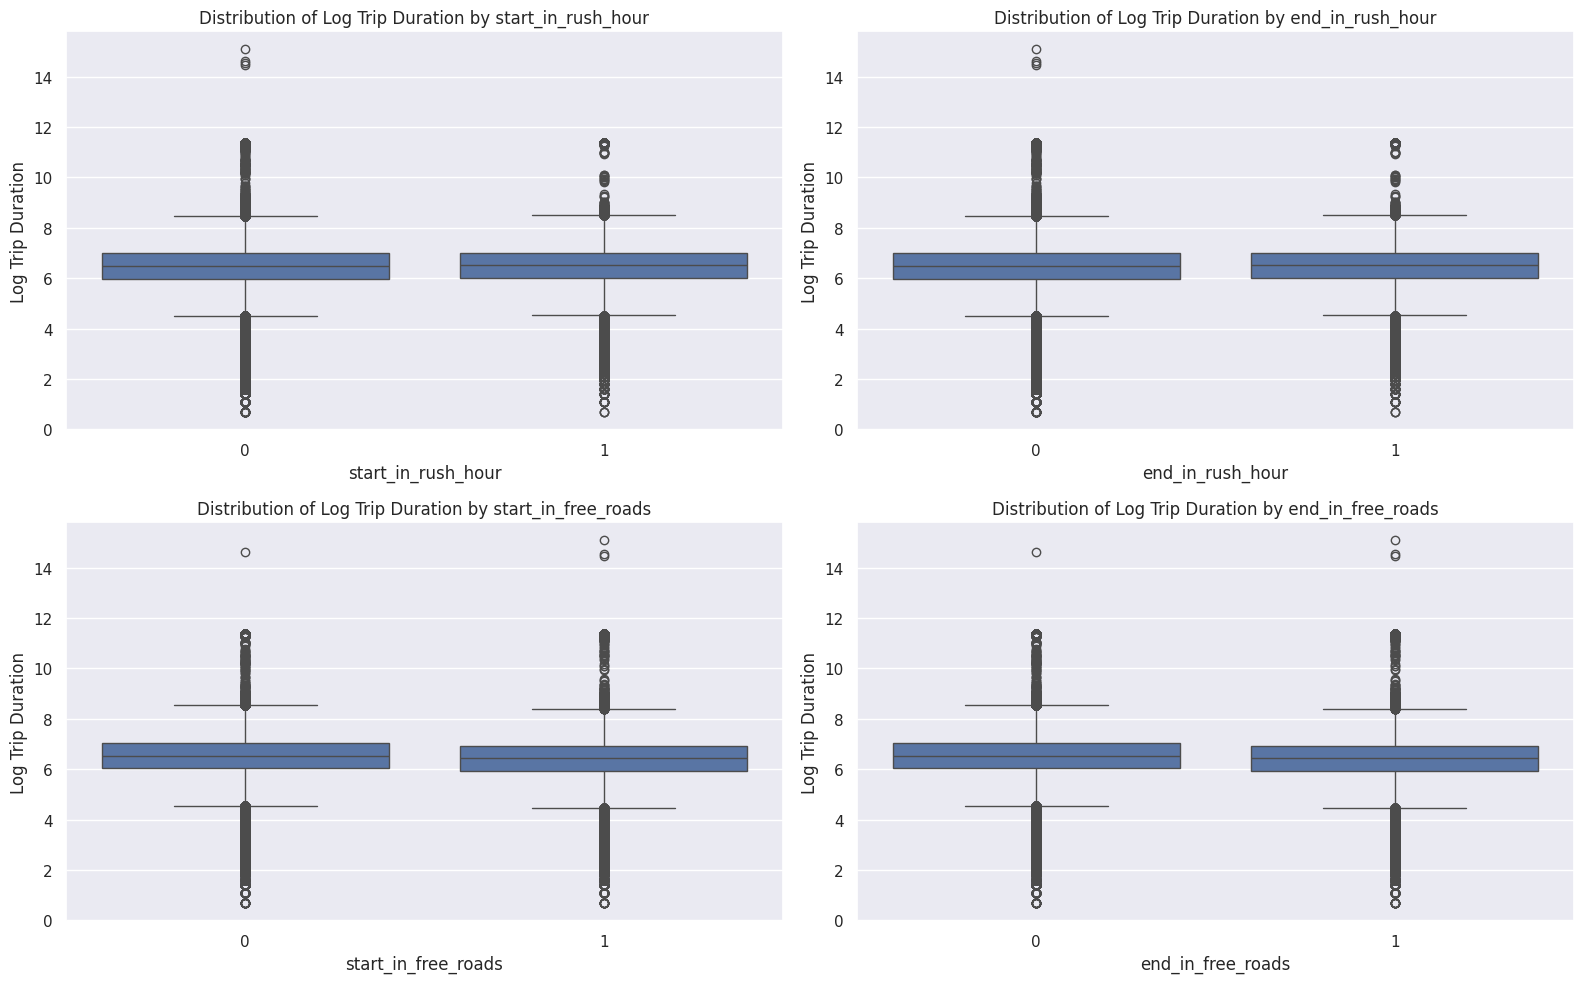

In [45]:
# Список признаков для которых нужно построить графики
features = ['start_in_rush_hour', 'end_in_rush_hour', 'start_in_free_roads', 'end_in_free_roads']

# Настроим графики
plt.figure(figsize=(16, 10))

# Для каждого признака создаем boxplot
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)  # 2 строки, 2 столбца
    sns.boxplot(x=train_df[feature], y=train_df['log_trip_duration'])
    plt.title(f'Distribution of Log Trip Duration by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Log Trip Duration')

# Показываем все графики
plt.tight_layout()
plt.show()


**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 8**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, grid_size=(10, 10)):
        """
        Initialize the transformer with a grid size.
        grid_size: tuple (rows, cols) specifying the grid dimensions.
        """
        self.grid_size = grid_size

    def show_map(self):
        """
        Visualizes the grid cells.
        You may want to visualize how the cells are represented, for instance, as a grid of squares.
        """
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Create a grid of lines
        for x in range(self.grid_size[0] + 1):
            ax.axhline(y=x, color='black', linewidth=1)
        for y in range(self.grid_size[1] + 1):
            ax.axvline(x=y, color='black', linewidth=1)
        
        ax.set_xticks(np.arange(self.grid_size[0] + 1))
        ax.set_yticks(np.arange(self.grid_size[1] + 1))
        ax.set_aspect('equal', 'box')
        plt.show()

    def fit(self, X=None, y=None):
        """
        Fit the transformer. In this example, it doesn't learn anything specific from the data,
        but you could modify it to calculate or infer grid parameters.
        """
        # If there were any parameters to learn from data, do it here.
        # Currently, it doesn't depend on X or y.
        return self

    def transform(self, X, y=None):
        """
        Transform the data X based on the grid map. 
        For this example, let's assume we map each data point to a grid cell.
        """
        # Assuming X is a 2D array where rows are data points (samples),
        # and columns represent coordinates (e.g., x, y positions).
        
        # Example transformation: Map each coordinate to a grid cell index.
        # Let's assume we map data points (X[:, 0], X[:, 1]) to grid cells.
        
        grid_x = np.clip(X[:, 0], 0, self.grid_size[0] - 1).astype(int)
        grid_y = np.clip(X[:, 1], 0, self.grid_size[1] - 1).astype(int)

        # Return the transformed data (grid cell indices for each data point)
        transformed = np.column_stack((grid_x, grid_y))
        
        return transformed


## Часть 3. Изучаем оставшиеся признаки

**Задание 9**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [47]:
unique_values = {
    'vendor_id': df['vendor_id'].nunique(),
    'passenger_count': df['passenger_count'].nunique(),
    'store_and_fwd_flag': df['store_and_fwd_flag'].nunique()
}

print(unique_values)

{'vendor_id': 2, 'passenger_count': 10, 'store_and_fwd_flag': 2}


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

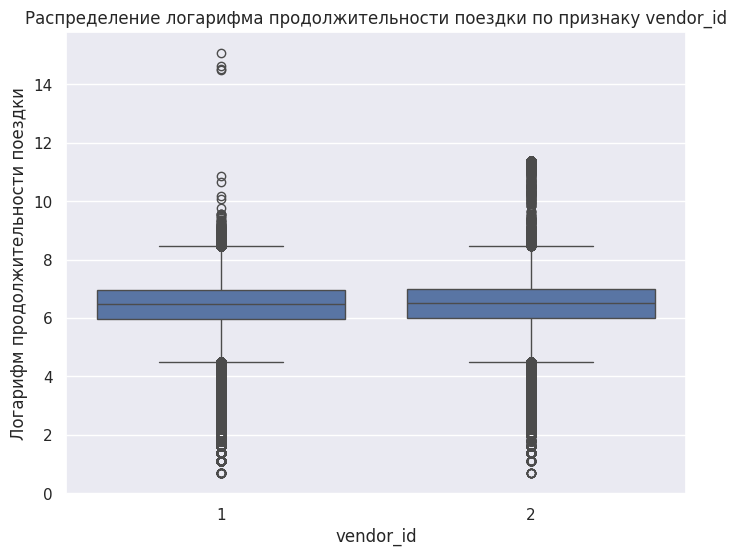

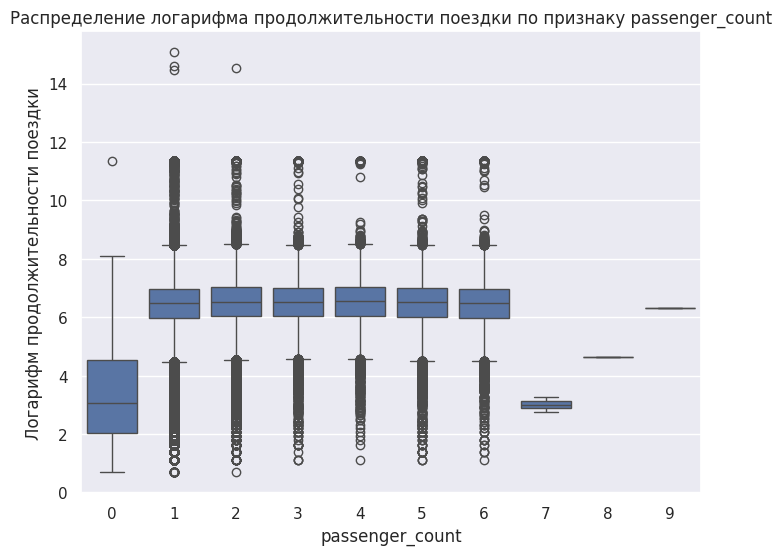

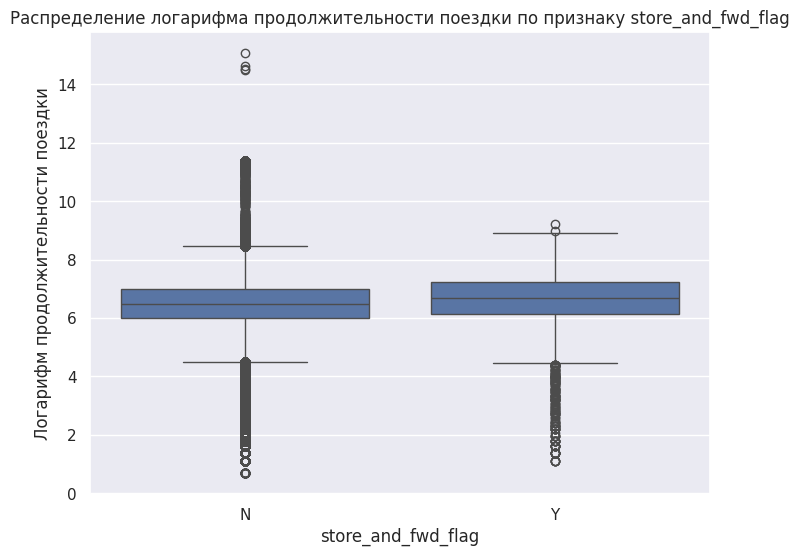

In [48]:
# Создание столбца log_trip_duration, если его еще нет
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# Список признаков
features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']

for feature in features:
    plt.figure(figsize=(8, 6))  # Настройка размера графика
    sns.boxplot(x=feature, y='log_trip_duration', data=df)
    plt.title(f'Распределение логарифма продолжительности поездки по признаку {feature}')
    plt.xlabel(f'{feature}')  # Название оси X
    plt.ylabel('Логарифм продолжительности поездки')  # Название оси Y
    plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [49]:
# Преобразуем vendor_id в бинарный формат
df['vendor_id'] = df['vendor_id'].map({1: 0, 2: 1})

# Преобразуем store_and_fwd_flag в бинарный формат
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

# Проверим результаты преобразования
print(df[['vendor_id', 'store_and_fwd_flag']].head())


   vendor_id  store_and_fwd_flag
0          1                   0
1          0                   0
2          1                   0
3          1                   0
4          1                   0


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

## Часть 4. Улучшаем данные

**Задание 10**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [51]:
# ВАШ КОД ТУТ

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 11**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 12**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут.

**Вопрос**: Почему такой признак потенциально полезный? 

In [ ]:
# ВАШ КОД ТУТ

**Задание 13 (бонус)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси.

In [ ]:
# ВАШ КОД ТУТ

**Задание 14 **. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

In [8]:
# ВАШ КОД ТУТ